In [1]:
import importlib
import terrain
import wind
import dynamics
#import visualization as vi

import numpy as np
importlib.reload(terrain)
importlib.reload(wind)
importlib.reload(dynamics)
#importlib.reload(vi)

# Ensure fresh module load
import sys
if 'era5vis.wind' in sys.modules:
    del sys.modules['era5vis.wind']
if 'era5vis.terrain' in sys.modules:
    del sys.modules['era5vis.terrain']
if 'era5vis.dynamics' in sys.modules:
    del sys.modules['era5vis.dynamics']

In [2]:
# Load terrain aspect dataset (pre-computed 1km)
terrain_ds = terrain.load_terrain_aspect_dataset()

terrain_ds['latitude'] = terrain_ds['latitude'].astype(np.float32)
terrain_ds['longitude'] = terrain_ds['longitude'].astype(np.float32)
terrain_ds['elevation'] = terrain_ds['elevation'].astype(np.int16)
terrain_ds['aspect_deg'] = terrain_ds['aspect_deg'].astype(np.int16)
terrain_ds['slope'] = terrain_ds['slope'].astype(np.int16)

terrain_ds


Loaded terrain aspect dataset: 232 x 772


<xarray.Dataset> Size: 1MB
Dimensions:       (latitude: 232, longitude: 772)
Coordinates:
  * latitude      (latitude) float32 928B 48.0 47.99 47.97 ... 45.03 45.01 45.0
  * longitude     (longitude) float32 3kB 6.0 6.013 6.026 ... 15.97 15.99 16.0
Data variables:
    elevation     (latitude, longitude) int16 358kB 335 336 339 ... 393 446 0
    aspect_deg    (latitude, longitude) int16 358kB 0 357 344 322 ... 102 100 99
    slope         (latitude, longitude) int16 358kB 1 1 1 1 1 1 ... 1 1 2 4 4 4
    terrain_mask  (latitude, longitude) bool 179kB ...
Attributes:
    resolution_m:   990
    min_elevation:  50.0
    min_slope:      3.0
    description:    Terrain slope aspect dataset computed from SRTM data

In [239]:
##Example usage to add terrain intersection to ERA5 data
import xarray as xr
terrain_ds = terrain.load_terrain_aspect_dataset('./terrain_cache/terrain_aspect_1km.nc')
era5_path = "./data/era5_example_dataset.nc"
era5_path = "./data/ERA5testAlps.nc"
era5_path = "/media/afriesinger/Volume/Projekte/Gleitschirmfliegen/Studium/Programming/SciProFinal/era5vis-main/era5vis/data/ERA5testAlps.nc"
era5_path = "/media/afriesinger/Volume/Projekte/Gleitschirmfliegen/Studium/Programming/SciProFinal/era5vis-main/era5vis/data/andi.nc"
era5_data = xr.open_dataset(era5_path)

#Compress to save memory
era5_data['latitude'] = era5_data['latitude'].astype(np.float32)
era5_data['longitude'] = era5_data['longitude'].astype(np.float32)
era5_data['pressure_level'] = era5_data['pressure_level'].astype(np.int16)

era5_data['t'] = era5_data['t'].astype(np.float16)
era5_data['z'] = era5_data['z'].astype(np.uint16)
era5_data['u'] = era5_data['u'].astype(np.float16)
era5_data['v'] = era5_data['v'].astype(np.float16)


## add geopotential height to ds
era5_data['gph'] = dynamics.geopotential_height(era5_data['z'])



#
#  Crop ERA5 to terrain extent to reduce computation
crop = False
if crop:
    crop_lat_min, crop_lat_max = 46,47
    crop_lon_min, crop_lon_max = 15,15

    era5_data = era5_data.sel(
        latitude=slice(crop_lat_max, crop_lat_min),  
        longitude=slice(crop_lon_min, crop_lon_max)
)



era_lat_max, era_lat_min = era5_data.latitude.max(),era5_data.latitude.min()
era_lon_max, era_lon_min = era5_data.longitude.max(),era5_data.longitude.min()



terrain_ds = terrain_ds.sel(
    latitude=slice(era_lat_max, era_lat_min),  # ERA5 lats are decreasing
    longitude=slice(era_lon_min, era_lon_max)
)



# Interpolate ERA5 onto terrain grid
highres = True
if highres:
    era5_on_terrain = terrain.interpolate_to_grid(era5_data, terrain_ds)
    era5_with_terrain = terrain.compute_terrain_intersection(era5_on_terrain, terrain_ds)
else:
    era5_with_terrain = terrain.compute_terrain_intersection(era5_data, terrain_ds)

crop2 = False
if crop2:
    # Crop to Bolzano-Munich region (~30km width)
    # Bolzano: 46.5°N, 11.3°E
    # Munich: 48.1°N, 11.6°E
    # Region center: ~47.3°N, 11.45°E
    # ~30km = ~0.27° latitude, ~0.27° longitude (at this latitude)
    crop_lat_center = 47.3
    crop_lon_center = 11.45
    crop_width = 0.27

    era5_with_terrain = era5_with_terrain.sel(
        latitude=slice(crop_lat_center + crop_width, crop_lat_center - crop_width),
        longitude=slice(crop_lon_center - crop_width, crop_lon_center + crop_width)
    )

    print(f"Cropped to Bolzano-Munich region:")
    print(f"  Lat: [{crop_lat_center - crop_width:.2f}, {crop_lat_center + crop_width:.2f}]°N")
    print(f"  Lon: [{crop_lon_center - crop_width:.2f}, {crop_lon_center + crop_width:.2f}]°E")
    print(f"  Shape: {era5_with_terrain.dims}")

data = era5_with_terrain

## add theta
data['theta'] = dynamics.potential_temperature(data['t'], data['pressure_level'])


Loaded terrain aspect dataset: 232 x 772


In [228]:
era5_data

<xarray.Dataset> Size: 91kB
Dimensions:         (valid_time: 1, pressure_level: 17, latitude: 13,
                     longitude: 41)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 8B 2025-09-02T12:00:00
  * pressure_level  (pressure_level) int16 34B 1000 975 950 925 ... 550 500 450
  * latitude        (latitude) float32 52B 48.0 47.75 47.5 ... 45.5 45.25 45.0
  * longitude       (longitude) float32 164B 6.0 6.25 6.5 ... 15.5 15.75 16.0
    number          int64 8B ...
    expver          <U4 16B ...
Data variables:
    t               (valid_time, pressure_level, latitude, longitude) int16 18kB ...
    u               (valid_time, pressure_level, latitude, longitude) float16 18kB ...
    v               (valid_time, pressure_level, latitude, longitude) float16 18kB ...
    z               (valid_time, pressure_level, latitude, longitude) uint16 18kB ...
    gph             (valid_time, pressure_level, latitude, longitude) uint16 18kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-10T14:21 GRIB to CDM+CF via cfgrib-0.9.1...

In [248]:
era5_with_terrain
era5_with_terrain['latitude'] = era5_with_terrain['latitude'].astype(np.float32)
era5_with_terrain['longitude'] = era5_with_terrain['longitude'].astype(np.float32)
era5_with_terrain['pressure_level'] = era5_with_terrain['pressure_level'].astype(np.int16)

era5_with_terrain['t'] = era5_with_terrain['t'].astype(np.float16)
era5_with_terrain['z'] = era5_with_terrain['z'].astype(np.uint16)
era5_with_terrain['u'] = era5_with_terrain['u'].astype(np.float16)
era5_with_terrain['v'] = era5_with_terrain['v'].astype(np.float16)
era5_with_terrain['z'] = era5_with_terrain['z'].astype(np.uint16)
era5_with_terrain['gph'] = era5_with_terrain['z'].astype(np.uint16)

era5_with_terrain

<xarray.Dataset> Size: 40MB
Dimensions:            (valid_time: 1, pressure_level: 17, latitude: 231,
                        longitude: 772)
Coordinates:
  * valid_time         (valid_time) datetime64[ns] 8B 2025-09-02T12:00:00
  * pressure_level     (pressure_level) int16 34B 1000 975 950 ... 550 500 450
  * latitude           (latitude) float32 924B 48.0 47.99 47.97 ... 45.03 45.01
  * longitude          (longitude) float32 3kB 6.0 6.013 6.026 ... 15.99 16.0
    number             int64 8B ...
    expver             <U4 16B ...
Data variables:
    t                  (valid_time, pressure_level, latitude, longitude) float16 6MB ...
    u                  (valid_time, pressure_level, latitude, longitude) float16 6MB ...
    v                  (valid_time, pressure_level, latitude, longitude) float16 6MB ...
    z                  (valid_time, pressure_level, latitude, longitude) uint16 6MB ...
    gph                (valid_time, pressure_level, latitude, longitude) uint16 6MB ...
    terrain            (valid_time, pressure_level, latitude, longitude) bool 3MB ...
    terrain_elevation  (latitude, longitude) int32 713kB 335 336 339 ... 434 0
    theta              (valid_time, pressure_level, latitude, longitude) float16 6MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-10T14:21 GRIB to CDM+CF via cfgrib-0.9.1...

In [243]:
# Step 2: Compute complete wind-terrain interaction (vectorized)
# Returns: wind_speed, wind_direction, downwind_terrain_height, perpendicular_wind_speed

era5_enhanced = wind.compute_wind_terrain_interaction(data, terrain_ds, range_km=3.0)


In [245]:
era5_enhanced

<xarray.Dataset> Size: 89MB
Dimensions:                   (valid_time: 1, pressure_level: 17,
                               latitude: 231, longitude: 772)
Coordinates:
  * valid_time                (valid_time) datetime64[ns] 8B 2025-09-02T12:00:00
  * pressure_level            (pressure_level) int16 34B 1000 975 ... 500 450
  * latitude                  (latitude) float32 924B 48.0 47.99 ... 45.03 45.01
  * longitude                 (longitude) float32 3kB 6.0 6.013 ... 15.99 16.0
    number                    int64 8B ...
    expver                    <U4 16B ...
Data variables:
    t                         (valid_time, pressure_level, latitude, longitude) float16 6MB ...
    u                         (valid_time, pressure_level, latitude, longitude) float16 6MB ...
    v                         (valid_time, pressure_level, latitude, longitude) float16 6MB ...
    z                         (valid_time, pressure_level, latitude, longitude) uint16 6MB ...
    gph                       (valid_time, pressure_level, latitude, longitude) float64 24MB ...
    terrain                   (valid_time, pressure_level, latitude, longitude) bool 3MB ...
    terrain_elevation         (latitude, longitude) int32 713kB 335 336 ... 0
    theta                     (valid_time, pressure_level, latitude, longitude) float16 6MB ...
    wind_speed                (valid_time, pressure_level, latitude, longitude) float16 6MB ...
    wind_direction            (valid_time, pressure_level, latitude, longitude) uint16 6MB ...
    downwind_terrain_height   (valid_time, pressure_level, latitude, longitude) uint16 6MB ...
    perpendicular_wind_speed  (valid_time, pressure_level, latitude, longitude) float32 12MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-10T14:21 GRIB to CDM+CF via cfgrib-0.9.1...

In [246]:
era5_enhancedNH = dynamics.compute_N_H(era5_enhanced)



/media/afriesinger/Volume/Projekte/Gleitschirmfliegen/Studium/Programming/SciProFinal/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [254]:
# Convert float16 variables to float32 for netCDF compatibility (netCDF doesn't support float16)
# This is only needed before saving to disk
era5_enhancedNH_save = era5_enhancedNH.copy()

# Convert theta from int16 to float32 (it was computed from float16 inputs)
if 'theta' in era5_enhancedNH_save.data_vars:
    era5_enhancedNH_save['theta'] = era5_enhancedNH_save['theta'].astype(np.float32)
    era5_enhancedNH_save['t'] = era5_enhancedNH_save['t'].astype(np.float32)
    era5_enhancedNH_save['u'] = era5_enhancedNH_save['u'].astype(np.float32)
    era5_enhancedNH_save['v'] = era5_enhancedNH_save['v'].astype(np.float32)
    era5_enhancedNH_save['wind_speed'] = era5_enhancedNH_save['wind_speed'].astype(np.float32)

print("Converted variables for netCDF compatibility:")
print(f"  theta: {era5_enhancedNH_save['theta'].dtype}")

era5_enhancedNH_save.to_netcdf('./data/era5_test_with_NH.nc')

Converted variables for netCDF compatibility:
  theta: float32


(array([5.483e+04, 5.040e+02, 1.620e+02, 9.900e+01, 5.700e+01, 3.600e+01,
        3.200e+01, 1.800e+01, 1.000e+01, 1.100e+01]),
 array([1.13537248e-02, 9.94809393e+01, 1.98950525e+02, 2.98420110e+02,
        3.97889696e+02, 4.97359282e+02, 5.96828867e+02, 6.96298453e+02,
        7.95768038e+02, 8.95237624e+02, 9.94707209e+02]),
 <BarContainer object of 10 artists>)

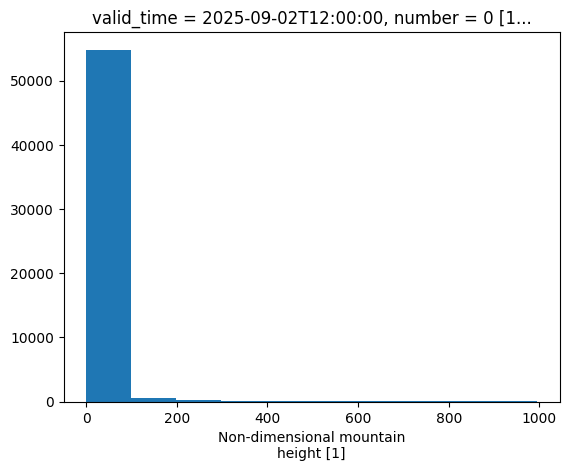

In [65]:
test  = era5_enhancedNH.H.where(era5_enhancedNH.H < 1000
                                )
test.mean()
test.plot()

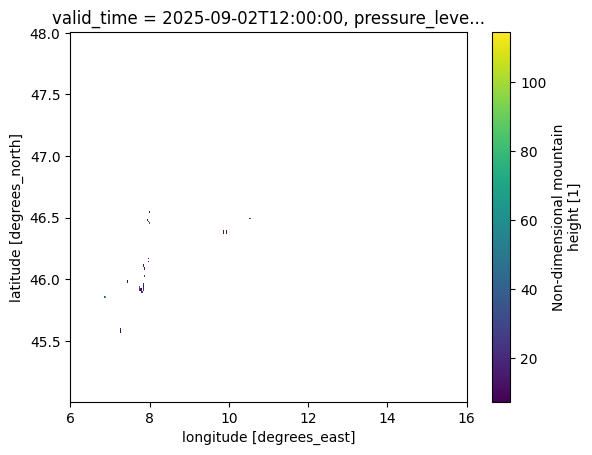

In [249]:

era5_enhancedNH.sel(
    pressure_level=700,

)['H'].plot()
#era5_enhancedNH



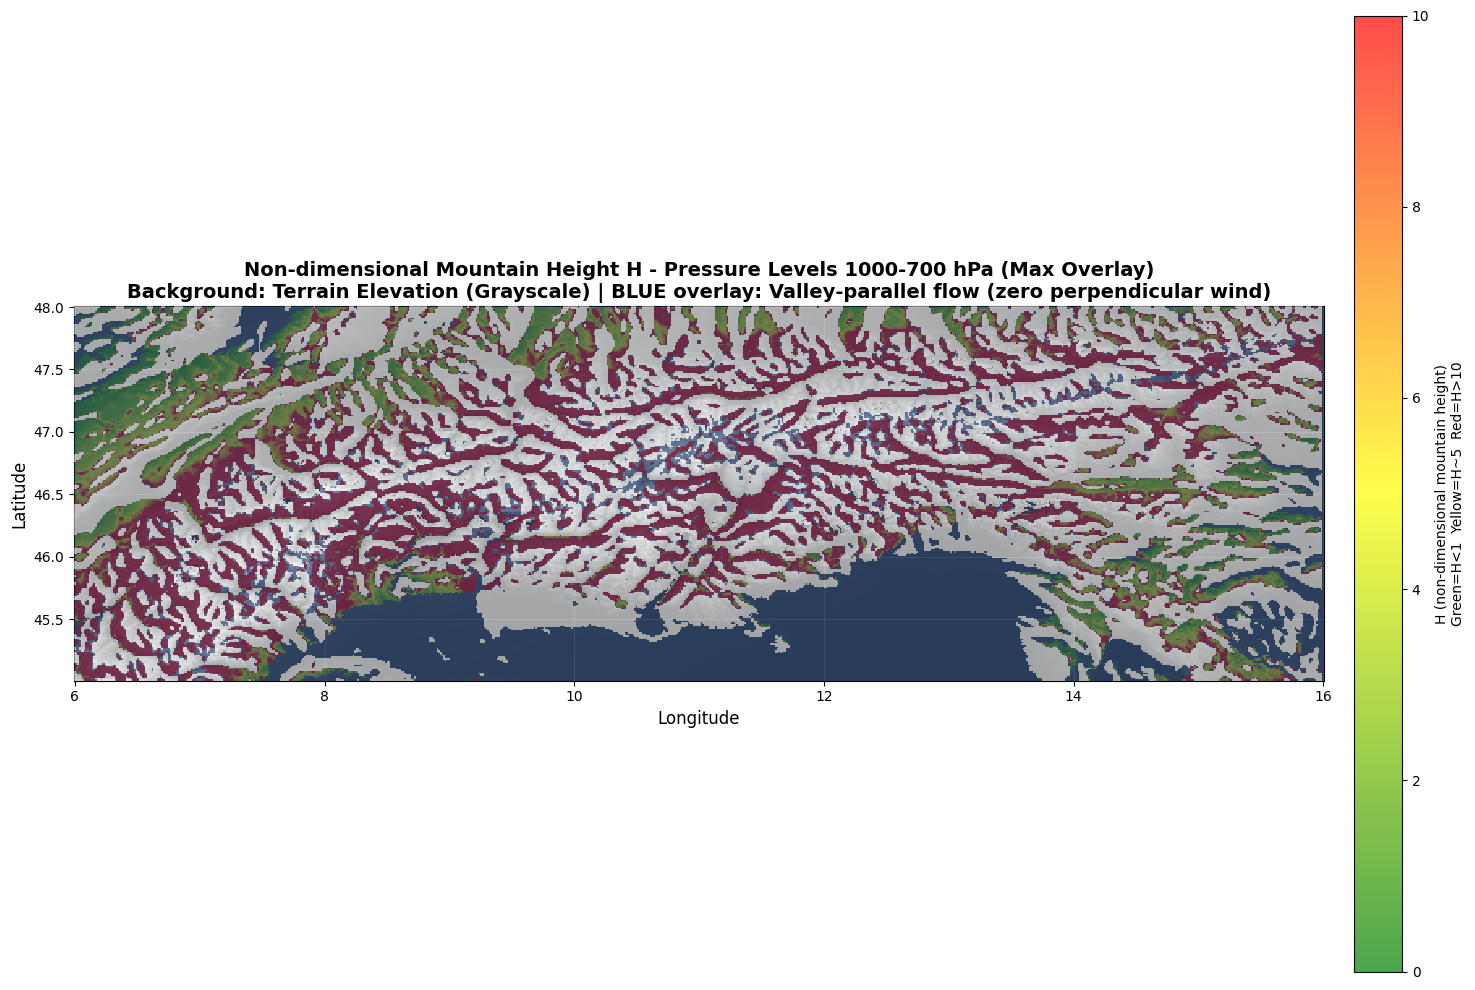

In [192]:
# Plot all pressure levels with blue overlay
print("=== H Parameter Visualization ===\n")

from matplotlib.colors import LinearSegmentedColormap

# Flatten pressure dimension: take max H across all pressure levels
H_flattened = era5_reduced_FIXED['H'].isel(valid_time=0).max(dim='pressure_level')

# Check perpendicular wind speed - identify regions with zero cross-mountain flow
perp_wind_max = era5_reduced_FIXED['perpendicular_wind_speed'].isel(valid_time=0).max(dim='pressure_level')
zero_wind_mask = perp_wind_max == 0


# Filter: drop values > 100
H_filtered = H_flattened.where(H_flattened <= 100)


# Extract terrain elevation
terrain_elev = era5_reduced_FIXED['terrain_elevation']

# Create custom colormap: green (H < 1) -> yellow (H ~ 5) -> red (H > 10)
colors_h = ['green', 'yellow', 'red']
cmap_h = LinearSegmentedColormap.from_list('H_colormap', colors_h, N=256)

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Create meshgrid
lon_mesh = np.meshgrid(H_flattened.longitude.values, H_flattened.latitude.values)[0]
lat_mesh = np.meshgrid(H_flattened.longitude.values, H_flattened.latitude.values)[1]

# Plot terrain as background (grayscale, more prominent)
terrain_norm = (terrain_elev.values - terrain_elev.min().values) / (terrain_elev.max().values - terrain_elev.min().values)
ax.pcolormesh(lon_mesh, lat_mesh, terrain_norm, cmap='gray', shading='auto', alpha=0.7, zorder=1)

# Plot H values with custom green-yellow-red colormap (semi-transparent)
im_h = ax.pcolormesh(lon_mesh, lat_mesh, H_filtered.values, cmap=cmap_h, shading='auto', alpha=0.7, zorder=2, vmin=0, vmax=10)

# Overlay BLUE where perpendicular wind is zero (valley-parallel flow) - separate scale
blue_overlay = zero_wind_mask.values.astype(float)
ax.pcolormesh(lon_mesh, lat_mesh, blue_overlay, cmap='Blues_r', shading='auto', alpha=0.5, zorder=3, vmin=0, vmax=1)

# Colorbar for H
cbar = plt.colorbar(im_h, ax=ax, pad=0.02, label='H (non-dimensional mountain height)\nGreen=H<1  Yellow=H~5  Red=H>10')

# Labels
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Non-dimensional Mountain Height H - All Pressure Levels (Max Overlay)\nBackground: Terrain Elevation (Grayscale) | BLUE overlay: Valley-parallel flow (zero perpendicular wind)', 
             fontsize=14, fontweight='bold')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save figure
fig.savefig('H_parameter_all_levels_with_blue_overlay.png', dpi=300)


In [250]:
# Analyze memory consumption of era5_enhancedNH variables
import sys

def get_var_size_mb(var):
    """Get size of a variable in MB"""
    return sys.getsizeof(var) / (1024 ** 2)

# For xarray datasets, we can check memory more comprehensively
def analyze_dataset_memory(ds):
    """Analyze memory usage for all variables in an xarray Dataset"""
    print(f"\n{'Variable':<30} {'Shape':<40} {'Size (MB)':<15} {'dtype':<10}")
    print("=" * 95)
    
    total_mb = 0
    var_sizes = {}
    
    for var_name in sorted(ds.data_vars):
        var = ds[var_name]
        size_mb = var.nbytes / (1024 ** 2)
        var_sizes[var_name] = size_mb
        total_mb += size_mb
        shape_str = str(var.shape)
        print(f"{var_name:<30} {shape_str:<40} {size_mb:>10.2f} MB    {str(var.dtype):<10}")
    
    # Sort by size
    sorted_vars = sorted(var_sizes.items(), key=lambda x: x[1], reverse=True)
    
    print("\n" + "=" * 95)
    print(f"{'TOTAL':<30} {'':<40} {total_mb:>10.2f} MB")
    print("=" * 95)
    
    print("\n\nTOP MEMORY CONSUMERS:")
    print("-" * 50)
    for i, (var_name, size_mb) in enumerate(sorted_vars, 1):
        percentage = (size_mb / total_mb) * 100
        print(f"{i}. {var_name:<25} {size_mb:>10.2f} MB  ({percentage:>5.1f}%)")
    
    return var_sizes

# Analyze era5_enhancedNH
memory_usage = analyze_dataset_memory(era5_enhancedNH)


Variable                       Shape                                    Size (MB)       dtype     
H                              (1, 17, 231, 772)                             11.56 MB    float32   
N                              (1, 17, 231, 772)                             11.56 MB    float32   
downwind_terrain_height        (1, 17, 231, 772)                              5.78 MB    uint16    
gph                            (1, 17, 231, 772)                              5.78 MB    uint16    
perpendicular_wind_speed       (1, 17, 231, 772)                             11.56 MB    float32   
t                              (1, 17, 231, 772)                              5.78 MB    float16   
terrain                        (1, 17, 231, 772)                              2.89 MB    bool      
terrain_elevation              (231, 772)                                     0.68 MB    int32     
theta                          (1, 17, 231, 772)                              5.78 MB    float16   


ValueError: 'darkbrown' is not a valid value for color: supported inputs are (r, g, b) and (r, g, b, a) 0-1 float tuples; '#rrggbb', '#rrggbbaa', '#rgb', '#rgba' strings; named color strings; string reprs of 0-1 floats for grayscale values; 'C0', 'C1', ... strings for colors of the color cycle; and pairs combining one of the above with an alpha value

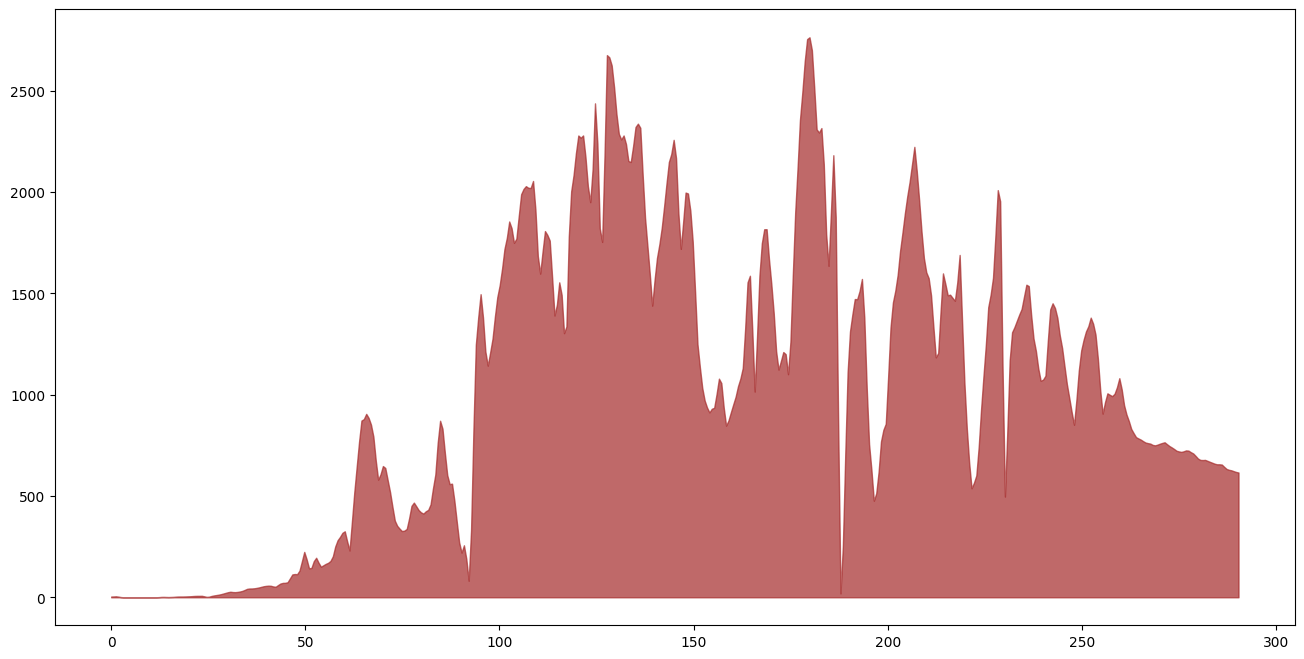

In [3]:
# Terrain cross-section: Venice to Munich
# Coordinates: Venice (45.43°N, 12.34°E) to Munich (48.14°N, 11.58°E)

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

# Define start and end points
venice_lat, venice_lon = 45.43, 12.34  # Venice
munich_lat, munich_lon = 48.14, 11.58  # Munich

# Create a line from Venice to Munich with 500 points
num_points = 500
lats_line = np.linspace(venice_lat, munich_lat, num_points)
lons_line = np.linspace(venice_lon, munich_lon, num_points)

# Get terrain data
terrain_elev = terrain_ds['elevation'].values
terrain_lats = terrain_ds['latitude'].values
terrain_lons = terrain_ds['longitude'].values

# Create interpolator for terrain elevation
interp_elev = RegularGridInterpolator(
    (terrain_lats[::-1], terrain_lons),
    terrain_elev[::-1, :],
    method='linear',
    bounds_error=False,
    fill_value=np.nan
)

# Interpolate terrain elevation along the profile line
points = np.stack([lats_line, lons_line], axis=-1)
elevation_profile = interp_elev(points)

# Calculate distance along the profile (in km)
lat_diff = (venice_lat - munich_lat) * 111  # 1 degree lat ≈ 111 km
lon_diff = (venice_lon - munich_lon) * 111 * np.cos(np.radians((venice_lat + munich_lat) / 2))
total_distance = np.sqrt(lat_diff**2 + lon_diff**2)
distances_km = np.linspace(0, total_distance, num_points)

# Create the cross-section plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot elevation profile
ax.fill_between(distances_km, 0, elevation_profile, alpha=0.7, color='brown', label='Terrain Elevation')
ax.plot(distances_km, elevation_profile, color='darkbrown', linewidth=2, label='Elevation Profile')

# Add markers for Venice and Munich
ax.axvline(x=0, color='blue', linestyle='--', linewidth=2, alpha=0.7, label='Venice')
ax.axvline(x=distances_km[-1], color='red', linestyle='--', linewidth=2, alpha=0.7, label='Munich')

# Formatting
ax.set_xlabel('Distance from Venice to Munich (km)', fontsize=12, fontweight='bold')
ax.set_ylabel('Elevation (m)', fontsize=12, fontweight='bold')
ax.set_title('Terrain Cross-Section: Venice → Munich\n(45.43°N, 12.34°E → 48.14°N, 11.58°E)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=11)
ax.set_ylim([0, elevation_profile.max() * 1.1])

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n{'='*70}")
print(f"TERRAIN CROSS-SECTION: VENICE → MUNICH")
print(f"{'='*70}")
print(f"Start Point (Venice):     45.43°N, 12.34°E")
print(f"End Point (Munich):       48.14°N, 11.58°E")
print(f"Total Distance:           {total_distance:.1f} km")
print(f"Number of Sample Points:  {num_points}")
print(f"\nElevation Statistics:")
print(f"  Minimum:                {np.nanmin(elevation_profile):.1f} m")
print(f"  Maximum:                {np.nanmax(elevation_profile):.1f} m")
print(f"  Mean:                   {np.nanmean(elevation_profile):.1f} m")
print(f"  Elevation Gain:         {max(0, elevation_profile[-1] - elevation_profile[0]):.1f} m")
print(f"{'='*70}\n")

In [4]:
# Export elevation profile to numpy files
import os
import numpy as np

output_dir = './terrain_crosssections'
os.makedirs(output_dir, exist_ok=True)

# Create 1D array: index = distance in km, value = elevation in meters
# Interpolate to 1 km resolution
elevation_1km = np.interp(np.arange(int(distances_km[-1]) + 1), distances_km, elevation_profile)

# Remove NaN values before converting to int32
elevation_1km = elevation_1km[~np.isnan(elevation_1km)].astype(np.int32)

# Save as single file
np.save(f'{output_dir}/venice_munich_crosssection.npy', elevation_1km)

elevation_1km


array([   3,    4,    2,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    1,    1,    1,    2,    3,    3,    4,    4,    5,
          6,    7,    4,    2,    7,   10,   14,   19,   24,   26,   25,
         28,   33,   41,   43,   44,   48,   53,   56,   56,   52,   60,
         69,   72,   92,  113,  117,  169,  207,  143,  168,  186,  151,
        162,  172,  198,  265,  300,  323,  259,  373,  597,  795,  878,
        895,  843,  702,  591,  647,  598,  498,  383,  345,  327,  335,
        417,  466,  436,  417,  424,  447,  551,  738,  852,  701,  570,
        530,  373,  239,  240,   94,  584, 1265, 1469, 1315, 1144, 1252,
       1412, 1535, 1674, 1787, 1828, 1758, 1887, 2007, 2027, 2020, 1974,
       1667, 1688, 1799, 1745, 1444, 1482, 1494, 1323, 1832, 2072, 2235,
       2270, 2200, 2000, 2116, 2312, 1804, 2138, 2670, 2609, 2415, 2276,
       2278, 2181, 2172, 2315, 2326, 2045, 1759, 1525, 1575, 1722, 1858,
       2038, 2172, 2238, 1936, 1783, 1997, 1931, 16

In [8]:
# Modify a specific value in elevation_1km
elevation_1km[elevation_1km == 81] = 900
elevation_1km[elevation_1km == 94] = 350
elevation_1km[elevation_1km == 239] = 400
elevation_1km[elevation_1km == 240] = 600
elevation_1km[elevation_1km == 350] = 800
elevation_1km[elevation_1km == 584] = 1100
elevation_1km[elevation_1km == 1323] = 1600
elevation_1km[elevation_1km == 581] = 681
elevation_1km[elevation_1km == 510] = 610
elevation_1km = elevation_1km[::-1]

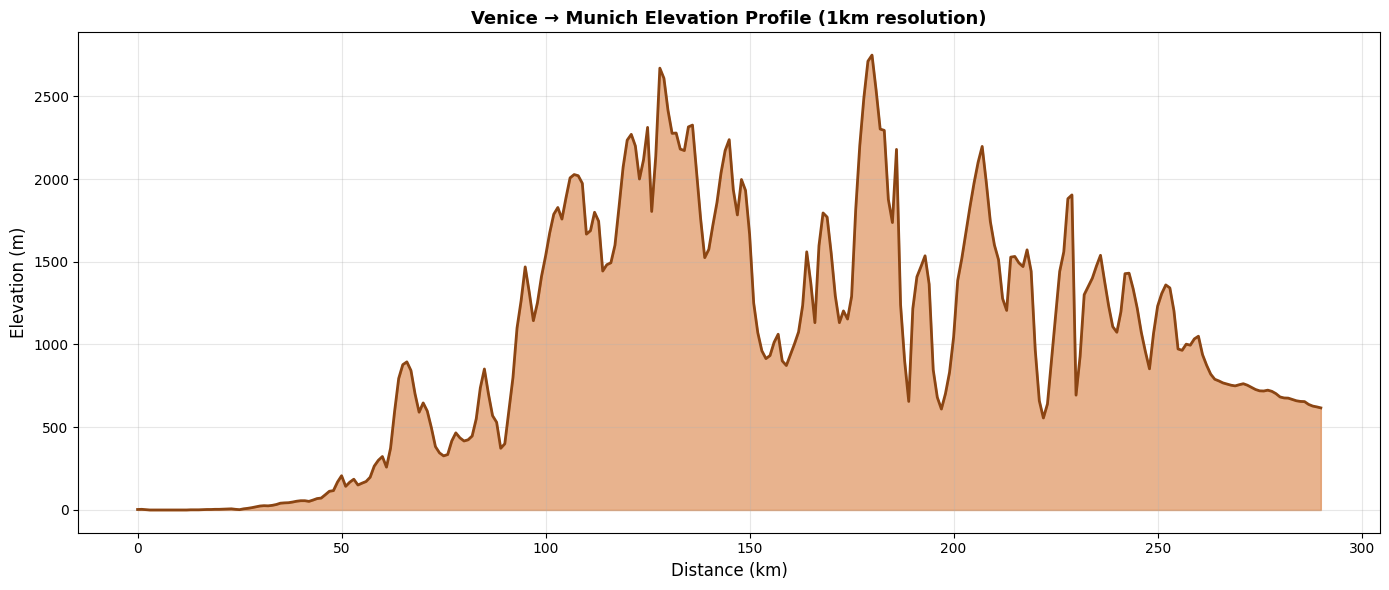

Array shape: (291,)
Min elevation: 0 m
Max elevation: 2749 m
Mean elevation: 1033.4 m


In [7]:
# Quick plot of the elevation array
plt.figure(figsize=(14, 6))
plt.plot(elevation_1km, linewidth=2, color='#8B4513')  # Saddle brown
plt.fill_between(range(len(elevation_1km)), elevation_1km, alpha=0.5, color='#D2691E')  # Chocolate
plt.xlabel('Distance (km)', fontsize=12)
plt.ylabel('Elevation (m)', fontsize=12)
plt.title('Venice → Munich Elevation Profile (1km resolution)', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Array shape: {elevation_1km.shape}")
print(f"Min elevation: {elevation_1km.min()} m")
print(f"Max elevation: {elevation_1km.max()} m")
print(f"Mean elevation: {elevation_1km.mean():.1f} m")


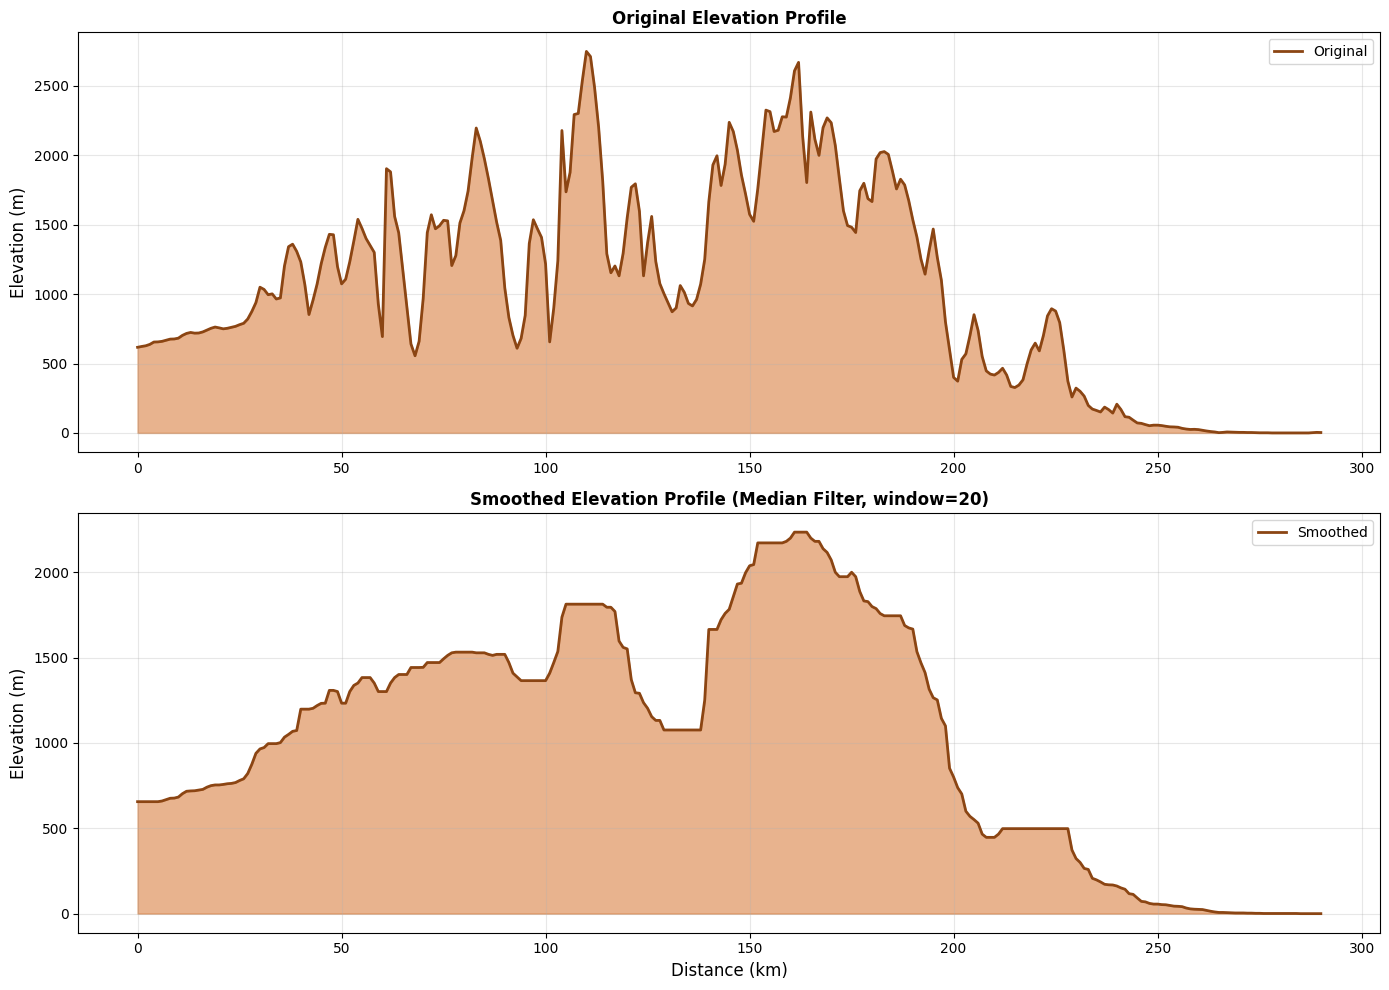

Anomaly smoothing applied:
  Original at 175-200: min=600, max=2027
  Smoothed at 175-200: min=852, max=2000

Smoothed array saved to: ./terrain_crosssections/venice_munich_crosssection_smooth.npy


In [9]:
# Smooth the anomaly between km 175-200
# Apply median filter to smooth out the spike
from scipy.ndimage import median_filter

elevation_1km_smooth = elevation_1km.copy()

# Apply median filter with window size of 5 to smooth anomalies
size = 20
elevation_1km_smooth = median_filter(elevation_1km_smooth, size=size)

# Save smoothed version
np.save(f'{output_dir}/venice_munich_crosssection_smooth.npy', elevation_1km_smooth.astype(np.int32))

# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Original
axes[0].plot(elevation_1km, linewidth=2, color='#8B4513', label='Original')
axes[0].fill_between(range(len(elevation_1km)), elevation_1km, alpha=0.5, color='#D2691E')
#axes[0].axvspan(175, 200, alpha=0.2, color='red', label='Smoothed region')
axes[0].set_ylabel('Elevation (m)', fontsize=12)
axes[0].set_title('Original Elevation Profile', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Smoothed
axes[1].plot(elevation_1km_smooth, linewidth=2, color='#8B4513', label='Smoothed')
axes[1].fill_between(range(len(elevation_1km_smooth)), elevation_1km_smooth, alpha=0.5, color='#D2691E')
#axes[1].axvspan(175, 200, alpha=0.2, color='green', label='Smoothed region')
axes[1].set_xlabel('Distance (km)', fontsize=12)
axes[1].set_ylabel('Elevation (m)', fontsize=12)
axes[1].set_title('Smoothed Elevation Profile (Median Filter, window='+ str(size) +')', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print("Anomaly smoothing applied:")
print(f"  Original at 175-200: min={elevation_1km[175:200].min()}, max={elevation_1km[175:200].max()}")
print(f"  Smoothed at 175-200: min={elevation_1km_smooth[175:200].min()}, max={elevation_1km_smooth[175:200].max()}")
print(f"\nSmoothed array saved to: {output_dir}/venice_munich_crosssection_smooth.npy")


In [30]:
len(elevation_1km_smooth)

291

In [39]:
# Export smoothed elevation to file
smooth_file = f'{output_dir}/venice_munich_crosssection_smooth20mod.npy'
np.save(smooth_file, elevation_1km_smooth.astype(np.int32))

print(f"Smoothed elevation array exported:")
print(f"  File: {smooth_file}")
print(f"  Shape: {elevation_1km_smooth.shape}")
print(f"  Data type: int32")
print(f"  Min: {elevation_1km_smooth.min()} m")
print(f"  Max: {elevation_1km_smooth.max()} m")
print(f"  Mean: {elevation_1km_smooth.mean():.1f} m")


Smoothed elevation array exported:
  File: ./terrain_crosssections/venice_munich_crosssection_smooth20mod.npy
  Shape: (291,)
  Data type: int32
  Min: 0 m
  Max: 2235 m
  Mean: 1042.6 m


In [ ]:
# Read the smoothed elevation file back in
elevation_loaded = np.load(f'{output_dir}/venice_munich_crosssection_smooth.npy')

print(f"Loaded smoothed elevation array:")
print(f"  Shape: {elevation_loaded.shape}")
print(f"  Data type: {elevation_loaded.dtype}")
print(f"  Min: {elevation_loaded.min()} m")
print(f"  Max: {elevation_loaded.max()} m")
print(f"  Mean: {elevation_loaded.mean():.1f} m")
print(f"\nFirst 10 values: {elevation_loaded[:10]}")
print(f"Last 10 values: {elevation_loaded[-10:]}")


In [41]:
import numpy as np
import sounddevice as sd

def play_tone(freq=440, duration=1.0, samplerate=44100):
    """Play a sine wave tone."""
    t = np.linspace(0, duration, int(samplerate * duration), endpoint=False)
    signal = 0.5 * np.sin(2 * np.pi * freq * t)
    sd.play(signal, samplerate)
    sd.wait()

play_tone()

In [42]:
pip install sounddevice

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
